# Figure 6: Terminal exon site analysis

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

Using TensorFlow backend.


## IMPORTS AND SETUP

In [4]:
import utilities
from utilities import genomic_context

import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.proportion import test_proportions_2indep


In [5]:
PROJECT = "/projects/b1080/eks/polyadenylation"
DATADIR = os.path.join(PROJECT, "manuscripts", "01_development", "data")
RESDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "analysis", "resources")
OUTDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "figures", "Figure_06")
os.makedirs(OUTDIR, exist_ok = True)


## Data loading and preparation

In [6]:
strongest_comb = pd.read_csv(os.path.join(RESDIR, f'20220121-215928.denom.all.te.strongest_vs_random.comb.txt'), sep = "\t")

strongest_comb['predictedStrength'] = strongest_comb['predicted_logit'].copy()
strongest_comb['matchStrength'] = strongest_comb['relstrength'] + strongest_comb['predictedStrength']

strongest_comb.loc[strongest_comb['distance_downstream_gene_antisense_log10'] >= strongest_comb['distance_downstream_gene_sense_log10'], 'downGeneType'] = 'sense'
strongest_comb.loc[strongest_comb['distance_downstream_gene_antisense_log10']  < strongest_comb['distance_downstream_gene_sense_log10'], 'downGeneType'] = 'antisense'

strongest_comb['downSenseDist']     = strongest_comb['distance_downstream_gene_sense_log10']
strongest_comb['downAntisenseDist'] = strongest_comb['distance_downstream_gene_antisense_log10']

print("\nStrongest all:\t", strongest_comb.shape)
print("\nDownstream gene orientation:\n", strongest_comb.downGeneType.value_counts())



Strongest all:	 (22410, 50)

Downstream gene orientation:
 antisense    12760
sense         9650
Name: downGeneType, dtype: int64


#### Subset pairs of terminal exonic sites meeting criteria

In [7]:
strongest_comb = strongest_comb.loc[~((strongest_comb['downGeneType'] == 'sense') & (strongest_comb['distance_down_log10'] == 0))].copy()

ext_te_genes = strongest_comb.loc[strongest_comb['feature'] == 'extended_terminal_exon', 'gene'].tolist()
strongest_comb2 = strongest_comb.loc[~strongest_comb['gene'].isin(ext_te_genes)]

print(strongest_comb.shape)
print(strongest_comb2.shape)


(22222, 50)
(14600, 50)


In [8]:
relusage_cutoff = 3
reldist_cutoff_lo = np.log10(100)
reldist_cutoff_hi = 4

mdata = strongest_comb.copy()

cond1 = (np.abs(mdata['relusage']) >= relusage_cutoff)
cond2 = (np.abs(mdata['reldist']) >= reldist_cutoff_lo)
cond3 = (np.abs(mdata['reldist']) <= reldist_cutoff_hi)

strongest_filt = mdata.loc[cond1 & cond2]
print(strongest_filt.shape)
    

(16334, 50)


#### Partition and scale data to normalize mean and standard deviation

In [9]:
termex_names_minimal = [
    'downAntisenseDist',
    'distance_first_upstream3ss_log10',
    'up_intron_log10',
    'predictedStrength',
    'matchStrength',
    'relstrength',
    'reldist'
]

termex_names_plus =  termex_names_minimal + ['downSenseDist', 'score_first_upstream3ss']


In [10]:
prox_filt, prox_all, prox_tr, prox_te, prox_scaler = genomic_context.prep_data(mdata, strongest_filt, termex_names_plus, 'relscore', 'score_logit', categorical = [], subset = ('comppos', 'proximal'))

(pXall_m, pXall_s, pYall_c, pYall_r) = prox_all
(pXtr_o_all, pXtr_s_all, pYtr_c_all, pYtr_r_all, pXtr_o_filt, pXtr_s_filt, pYtr_c_filt, pYtr_r_filt) = prox_tr
(pXte_o_all, pXte_s_all, pYte_c_all, pYte_r_all, pXte_o_filt, pXte_s_filt, pYte_c_filt, pYte_r_filt) = prox_te

pAll_c = pXall_m
pAll_c['outcome'] = pYall_c

pTr_c_filt = pXtr_s_filt
pTr_c_filt['outcome'] = pYtr_c_filt

pTe_c_filt = pXte_s_filt
pTe_c_filt['outcome'] = pYte_c_filt


After filtering for: ('comppos', 'proximal')
	All data =  (11111, 50)
	Filt data =  (8167, 50)
	Train/test splits =  train    6584
val       793
test      790
Name: split, dtype: int64
CAT: []
NONCAT: ['downAntisenseDist', 'distance_first_upstream3ss_log10', 'up_intron_log10', 'predictedStrength', 'matchStrength', 'relstrength', 'reldist', 'downSenseDist', 'score_first_upstream3ss']


### Comparison Models

In [11]:
feature_dict = {
    'predictedStrength' : 'PolyaStrength of proximal site',
    'matchStrength'     : 'PolyaStrength of paired distal site',
    'relstrength'       : 'Difference in PolyaStrength (distal-proximal)',
    'reldist'           : 'Distance between sites (log10)',
    'up_intron_log10'   : 'Upstream intron size (log10)',
    'downAntisenseDist' : 'Downstream antisense gene distance (log10)',
}


#### Fit logistic regression model

In [12]:
ffo_pmod = smf.logit(formula = "outcome ~ relstrength + up_intron_log10 + reldist + downAntisenseDist", 
                        data = pTr_c_filt).fit(disp = 0)
print(ffo_pmod.summary())

ffo_all_pred_c     = ffo_pmod.predict(pAll_c)
ffo_filt_tr_pred_c = ffo_pmod.predict(pTr_c_filt)
ffo_filt_te_pred_c = ffo_pmod.predict(pTe_c_filt)

ffo_tr_auroc, ffo_tr_auprc = genomic_context.calculate_auc(pYtr_c_filt, ffo_filt_tr_pred_c)
ffo_te_auroc, ffo_te_auprc = genomic_context.calculate_auc(pYte_c_filt, ffo_filt_te_pred_c)
print("FFO AUROC: Train = ", ffo_tr_auroc, ", Test = ", ffo_te_auroc)
print("FFO AUPRC: Train = ", ffo_tr_auprc, ", Test = ", ffo_te_auprc)

with open(os.path.join(OUTDIR, 'proximal_comparison.model.pickle'), mode = 'wb') as handle:
    pickle.dump(ffo_pmod, handle)
    
with open(os.path.join(OUTDIR, 'proximal_comparison.scaler.pickle'), mode = 'wb') as handle:
    pickle.dump(prox_scaler, handle)
    
with open(os.path.join(OUTDIR, 'proximal_comparison.training.pickle'), mode = 'wb') as handle:
    pickle.dump(prox_tr, handle)
    
with open(os.path.join(OUTDIR, 'proximal_comparison.testing.pickle'), mode = 'wb') as handle:
    pickle.dump(prox_te, handle)


                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                 7377
Model:                          Logit   Df Residuals:                     7372
Method:                           MLE   Df Model:                            4
Date:                Sat, 15 Jul 2023   Pseudo R-squ.:                  0.5208
Time:                        03:17:08   Log-Likelihood:                -2431.4
converged:                       True   LL-Null:                       -5074.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.4888      0.037     13.081      0.000       0.416       0.562
relstrength          -3.0634      0.072    -42.746      0.000      -3.204      -2.923
up_intron_log10      -0.

#### Combining Original Data and Model Predictions

In [13]:
## match up predictions to original data

# all

strongest_pred_all = mdata.copy()

strongest_pred_all.loc[pYall_c.index, 'pred_prob'] = ffo_all_pred_c

strongest_pred_all['pred_class']     = (strongest_pred_all['pred_prob'] >= 0.5).astype(int)
strongest_pred_all['pred_prob_clip'] = np.clip(strongest_pred_all['pred_prob'], 1e-6, 1 - 1e-6)
strongest_pred_all['pred_prob_or']   = np.log2(strongest_pred_all['pred_prob_clip'] / (1 - strongest_pred_all['pred_prob_clip']))

strongest_pred_all.loc[(strongest_pred_all['relscore'] == 1) & (strongest_pred_all['pred_class'] == 1), 'pred_type'] = 'true_positive'
strongest_pred_all.loc[(strongest_pred_all['relscore'] == 1) & (strongest_pred_all['pred_class'] == 0), 'pred_type'] = 'false_negative'
strongest_pred_all.loc[(strongest_pred_all['relscore'] == 0) & (strongest_pred_all['pred_class'] == 1), 'pred_type'] = 'false_positive'
strongest_pred_all.loc[(strongest_pred_all['relscore'] == 0) & (strongest_pred_all['pred_class'] == 0), 'pred_type'] = 'true_negative'

# filtered

strongest_pred = strongest_filt.copy()

strongest_pred.loc[ffo_filt_tr_pred_c.index, 'pred_prob'] = ffo_filt_tr_pred_c
strongest_pred.loc[ffo_filt_te_pred_c.index, 'pred_prob'] = ffo_filt_te_pred_c

strongest_pred['pred_class']     = (strongest_pred['pred_prob'] >= 0.5).astype(int)
strongest_pred['pred_prob_clip'] = np.clip(strongest_pred['pred_prob'], 1e-6, 1 - 1e-6)
strongest_pred['pred_prob_or']   = np.log2(strongest_pred['pred_prob_clip'] / (1 - strongest_pred['pred_prob_clip']))

strongest_pred.loc[(strongest_pred['relscore'] == 1) & (strongest_pred['pred_class'] == 1), 'pred_type'] = 'true_positive'
strongest_pred.loc[(strongest_pred['relscore'] == 1) & (strongest_pred['pred_class'] == 0), 'pred_type'] = 'false_negative'
strongest_pred.loc[(strongest_pred['relscore'] == 0) & (strongest_pred['pred_class'] == 1), 'pred_type'] = 'false_positive'
strongest_pred.loc[(strongest_pred['relscore'] == 0) & (strongest_pred['pred_class'] == 0), 'pred_type'] = 'true_negative'

print(strongest_pred.pred_type.value_counts() / len(strongest_pred))
print(strongest_pred_all.pred_type.value_counts() / len(strongest_pred_all))


true_negative     0.463144
false_negative    0.257683
true_positive     0.242317
false_positive    0.036856
Name: pred_type, dtype: float64
true_negative     0.464765
false_negative    0.301683
true_positive     0.199172
false_positive    0.034380
Name: pred_type, dtype: float64


In [14]:
matched_sites_dict = {}

for i, row in strongest_pred.iterrows():
    
    if (row['gene'] not in matched_sites_dict):
        matched_sites_dict[row['gene']] = {}
    
    matched_sites_dict[row['gene']][row['comppos']] = {
        'comptype' : row['comptype'], 
        'pred_prob' : row['pred_prob'],
    }

strongest_pred['pred_prob_norm']      = strongest_pred.apply(lambda row : row['pred_prob'] / (matched_sites_dict[row['gene']]['proximal']['pred_prob'] + matched_sites_dict[row['gene']]['distal']['pred_prob']), axis = 1)
strongest_pred['pred_prob_norm_clip'] = np.clip(strongest_pred['pred_prob_norm'], 1e-6, 1 - 1e-6)
strongest_pred['pred_prob_norm_or']   = np.log2(strongest_pred['pred_prob_norm_clip'] / (1 - strongest_pred['pred_prob_norm_clip']))


## Classification Performance

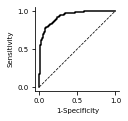

Corresponding metrics:
	Test AUROC = 0.9285852713178295


In [15]:
fig,ax = plt.subplots(1, 1, figsize = (1.75,1.75))

prox_auc = genomic_context.plot_roc(ax, 
                                    strongest_pred.loc[(strongest_pred['comppos'] == 'proximal') & (strongest_pred['split'] == 'test'), 'relscore'], 
                                    strongest_pred.loc[(strongest_pred['comppos'] == 'proximal') & (strongest_pred['split'] == 'test'), 'pred_prob'],
                                    'Test')


ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))

ax.get_legend().remove()

plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'classification_roc.proximal_test.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding metrics:")
print(f"\tTest AUROC = {prox_auc}")


## Validation of site usage predictions using ENCODE RNA-seq

In [16]:
ENCODE_DIR = os.path.join(PROJECT, "model", "rna_validation", "encode_project")

strongest_prox = strongest_pred.loc[strongest_pred['comppos'] == 'proximal'].copy()
print(strongest_prox.shape)


(8167, 58)


Original data shape: (8167, 58)
Filtered data shape: (8162, 58)
Output results shape: (8162, 2)


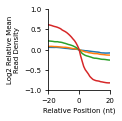

In [17]:
fig, ax = plt.subplots(1,1, figsize = (1.75,1.75))

distance = 20
prox_a172_res = genomic_context.quantify_reads_around(strongest_prox, ENCODE_DIR, 'A172', distance = distance, subset = [('distance_first_upstream3ss_log10', np.log10(distance))])
genomic_context.make_read_plots(ax, prox_a172_res, 'proximal_terminal_exon', 'A172', distance)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.get_legend().remove()
ax.set_ylim((-1,1))

plt.tight_layout(rect = [0, 0.03, 0.97, 1])
plt.savefig(os.path.join(OUTDIR, 'rna_validation.proximal.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


## Confirmatory boxplots for model predictors

In [18]:
hilo_perc = 50
hilo_cuts = [0, (100-hilo_perc)/100, 1]
hilo_labs = ['Low', 'High']
palette   = ["#a4c9e3", "#245475"]

strongest_prox['cuts'], cut_bins = pd.qcut(strongest_prox['score_logit'], q = hilo_cuts, labels = hilo_labs, retbins = True)
print(strongest_prox['cuts'].value_counts())


Low     4084
High    4083
Name: cuts, dtype: int64


In [19]:
selected_features = ['predictedStrength', 'matchStrength', 'relstrength', 'up_intron_log10', 'reldist', 'downAntisenseDist']
selected_labels   = [feature_dict[f] for f in selected_features]


#### PolyaStrength by site usage

PolyaStrength of proximal site:
N_Low	N=4084
N_High	N=4083
Baseline	WRS P-val = 0.000E+00


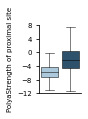

In [20]:
genomic_context.boxplot_features_outcome(OUTDIR, strongest_prox, 'te',
                                         ['predictedStrength'], [feature_dict.get("predictedStrength")],
                                         'cuts', ['Low','High'], palette,
                                         figsize = (0.75,1.25), ylims_main=(-12,8), ytickint_main = 4)


#### Paired site strength by site usage

PolyaStrength of paired distal site:
N_Low	N=4084
N_High	N=4083
Baseline	WRS P-val = 0.000E+00


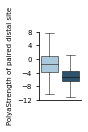

In [21]:
genomic_context.boxplot_features_outcome(OUTDIR, strongest_prox, 'te',
                                         [selected_features[1]], [selected_labels[1]],
                                         'cuts', ['Low','High'], palette,
                                         figsize = (0.75,1.25), ylims_main=(-12,8), ytickint_main = 4)


Difference in PolyaStrength (distal-proximal):
N_Low	N=4084
N_High	N=4083
Baseline	WRS P-val = 0.000E+00


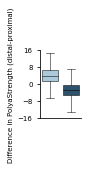

In [22]:
genomic_context.boxplot_features_outcome(OUTDIR, strongest_prox, 'te',
                                         [selected_features[2]], [selected_labels[2]],
                                         'cuts', ['Low','High'], palette,
                                         figsize = (0.75,1.25), ylims_main=(-16,16), ytickint_main = 8)


#### Genomic features after controlling for PolyaStrength and strength difference via quantile sampling

STARTING QUANTILE SAMPLING
Sampling by predictedStrength, relstrength


/projects/b1080/eks/polyadenylation/manuscripts/01_development/utilities/genomic_context.py:282: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  bin_cut_mins = bin_cut_counts.loc[bin_cut_counts.groupby(sample_var_bins)['count'].idxmin()].copy()


Final state: 2755630887 0.7964786770380483 0.08867718264422435
Upstream intron size (log10):
N_Low	N=1048
N_High	N=1048
Baseline	WRS P-val = 3.027E-11


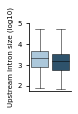

In [23]:
p_sampled = genomic_context.twovar_quantile_sampling(OUTDIR, strongest_prox, 
                                                     selected_features[3], selected_labels[3],
                                                     'score_logit', 'Actual usage (logit)', 
                                                     ['predictedStrength','relstrength'],
                                                     hilo_labs = ['Low','High'],
                                                     random_state = 2755630887)

genomic_context.boxplot_features_outcome(OUTDIR, p_sampled, 'te',
                                         [selected_features[3]], [selected_labels[3]],
                                         'cuts', ['Low','High'], palette,
                                         figsize = (0.75,1.25), ylims_main=(1.75,5), ytickint_main = 1)


STARTING QUANTILE SAMPLING
Sampling by predictedStrength, relstrength


/projects/b1080/eks/polyadenylation/manuscripts/01_development/utilities/genomic_context.py:282: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  bin_cut_mins = bin_cut_counts.loc[bin_cut_counts.groupby(sample_var_bins)['count'].idxmin()].copy()


Final state: 2898731213 0.9831840702938913 0.05016060333087182
Distance between sites (log10):
N_Low	N=1048
N_High	N=1048
Baseline	WRS P-val = 1.111E-22


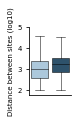

In [24]:
p_sampled = genomic_context.twovar_quantile_sampling(OUTDIR, strongest_prox, 
                                                     selected_features[4], selected_labels[4],
                                                     'score_logit', 'Actual usage (logit)', 
                                                     ['predictedStrength','relstrength'],
                                                     hilo_labs = ['Low','High'],
                                                     random_state = 2898731213)

genomic_context.boxplot_features_outcome(OUTDIR, p_sampled, 'te',
                                         [selected_features[4]], [selected_labels[4]],
                                         'cuts', ['Low','High'], palette,
                                         figsize = (0.75,1.25), ylims_main=(1.75,5), ytickint_main = 1)


STARTING QUANTILE SAMPLING
Sampling by predictedStrength, relstrength


/projects/b1080/eks/polyadenylation/manuscripts/01_development/utilities/genomic_context.py:282: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  bin_cut_mins = bin_cut_counts.loc[bin_cut_counts.groupby(sample_var_bins)['count'].idxmin()].copy()


Final state: 2465601090 0.9670661246134262 0.0649254512495297
Downstream antisense gene distance (log10):
N_Low	N=1048
N_High	N=1048
Baseline	WRS P-val = 2.114E-07


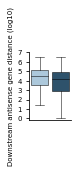

In [25]:
p_sampled = genomic_context.twovar_quantile_sampling(OUTDIR, strongest_prox, 
                                                     selected_features[5], selected_labels[5],
                                                     'score_logit', 'Actual usage (logit)', 
                                                     ['predictedStrength','relstrength'],
                                                     hilo_labs = ['Low','High'],
                                                     random_state = 2465601090)

genomic_context.boxplot_features_outcome(OUTDIR, p_sampled, 'te',
                                         [selected_features[5]], [selected_labels[5]],
                                         'cuts', ['Low','High'], palette,
                                         figsize = (0.75,1.25), ylims_main=(-0.2,7), ytickint_main = 1)


#### Visualization of controlled strength and strength difference

predictedStrength WRS P-val = 9.671E-01


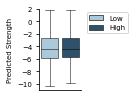

In [26]:
fig,ax = plt.subplots(1,1, figsize = (0.75, 1.5))

sns.boxplot(data = p_sampled, x = 'cuts', y = 'predictedStrength', order = ['Low','High'],
            hue = 'cuts', hue_order = ['Low','High'], palette = palette, dodge = False,
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black'},
            ax = ax, showfliers = False)

wrs = st.ranksums(p_sampled.loc[p_sampled['cuts'] == 'Low', 'predictedStrength'],
                  p_sampled.loc[p_sampled['cuts'] == 'High', 'predictedStrength'])[1]

print(f"predictedStrength WRS P-val = {wrs:.03E}")

ax.set_ylim(-11,2)
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.set_ylabel('Predicted Strength')

ax.set_xticks([])
ax.set_xlabel("")

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'{selected_features[5]}_by_usage.comppos_proximal.control.predstr.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


relStrength WRS P-val = 6.493E-02


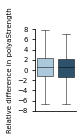

In [27]:
fig,ax = plt.subplots(1,1, figsize = (0.75, 1.5))

sns.boxplot(data = p_sampled, x = 'cuts', y = 'relstrength', order = ['Low','High'],
            hue = 'cuts', hue_order = ['Low','High'], palette = palette, dodge = False,
            boxprops = {'edgecolor' : 'black', 'linewidth' : 0.5},
            medianprops = {'color' : 'black', 'linewidth' : 0.5},
            whiskerprops = {'color' : 'black', 'linewidth' : 0.5},
            capprops = {'color' : 'black', 'linewidth' : 0.5},
            flierprops = {'color' : 'black'},
            ax = ax, showfliers = False)

wrs = st.ranksums(p_sampled.loc[p_sampled['cuts'] == 'Low', 'relstrength'],
                  p_sampled.loc[p_sampled['cuts'] == 'High', 'relstrength'])[1]

print(f"relStrength WRS P-val = {wrs:.03E}")

ax.get_legend().remove()
ax.set_ylim(-8,8)
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.set_ylabel('Relative difference in polyaStrength')

ax.set_xticks([])
ax.set_xlabel("")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, f'{selected_features[5]}_by_usage.comppos_proximal.control.relstrength.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()
